In [2]:
%load_ext autoreload
%autoreload 2

import fooof
from fooof.sim.gen import gen_aperiodic      # for looking at aperiodic details
from fooof.plts.spectra import plot_spectrum # for looking at aperiodic details
from fooof.plts.peaks import  
#from fooof.plts.annotate import plot_annotated_peak_search

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cycler
from matplotlib.colors import LinearSegmentedColormap
import matplotlib as mpl
from scipy.io import loadmat
import math

from data_utils import load_and_fit, invert_peak_data
from plot_tools import plotFlatComps, peakPlot, peakDataScatter, exponentPlot, peakDistr
from fooof.sim.gen import gen_power_spectrum

import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning) 

from fooof.plts.annotate import plot_annotated_peak_search 

In [2]:
pip install fooof

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


# Investigating spectra

- How do oscillations relate to dipole brain region?
- So far have been looking across components, not conditions (4 avg'd curves)

Other things:
- To see goodness of fit: fg.get_params('r_squared')

## FOOOF Settings

`peak_width_limits` sets the possible lower- and upper-bounds for the fitted peak widths.

`max_n_peaks sets` the maximum number of peaks to fit.

`min_peak_height` sets an absolute limit on the minimum height (above aperiodic) for any extracted peak.

`peak_threshold` sets a relative threshold above which a peak height must cross to be included in the model.

`aperiodic_mode` defines the approach to use to parameterize the aperiodic component.

## [Returning parameters](https://fooof-tools.github.io/fooof/generated/fooof.FOOOF.html#fooof.FOOOF.get_params) `.get_params()` 

`peak_params`
- CF: center frequency of the extracted peak
- PW: power of the peak, over and above the aperiodic component
- BW: bandwidth of the extracted peak

`aperiodic_params`
- exponent

#### Resources
- https://fooof-tools.github.io/fooof/generated/fooof.FOOOFGroup.html
- https://fooof-tools.github.io/fooof/#

### Testing grounds: changing `min_peak_height` to find components w/o oscillations

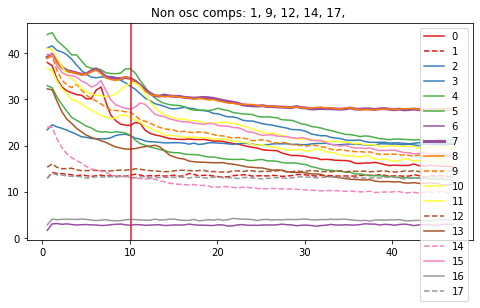

In [3]:
p_spectrum = loadmat('brian_diponly_3_spectra.mat')
specfreqs, specdata = p_spectrum['specfreqs'][0], p_spectrum['specdata']
group_spec = specdata.mean(0)[0]
fg = fooof.FOOOFGroup(aperiodic_mode='fixed', verbose = False, min_peak_height = 0.025)
fg.fit(specfreqs, group_spec.T, [3, 40])
oscs = fg.get_params('peak_params', 'CF')
bumpy_comps = set([int(i) for i in oscs[:,1]])

n_ = group_spec.shape[1]
color = plt.cm.Set1(np.linspace(0, 1,n_)) #color = cmap(np.linspace(0, 1,n_))
mpl.rcParams['axes.prop_cycle'] = cycler.cycler('color', color)
flat_comps = 'Non osc comps: '
plt.figure(figsize=(8,4))
for i in range(n_):
    lw = 1.5
    linestyle = '-'
    if i not in bumpy_comps:
        linestyle = '--'
        flat_comps += "{}, ".format(i)
    if i == 7: lw = 3
    plt.plot(specfreqs[:84], group_spec[:,i][:84], linestyle = linestyle, marker='',markevery=[17],label = str(i), lw = lw)
plt.axvline(10.151271039)
plt.legend()
plt.title(flat_comps)
plt.show()


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.56 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.



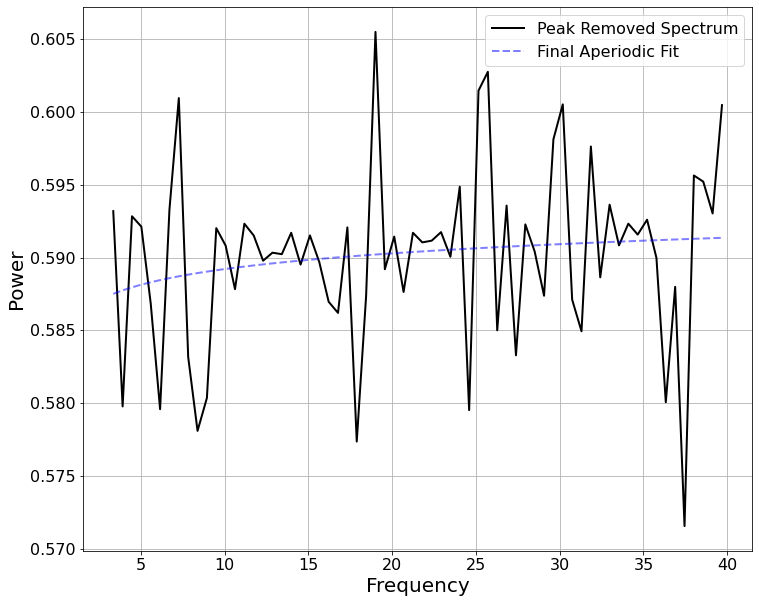

In [4]:
test_spec = group_spec[:,16]; plt_log = 0;
fm = fooof.FOOOF(aperiodic_mode='fixed')
fm.add_data(specfreqs,test_spec, [3, 40])
fm.fit(specfreqs, test_spec, [3, 40])
_, ax = plt.subplots(figsize=(12, 10))
plot_spectrum(fm.freqs, fm._spectrum_peak_rm, plt_log,
              label='Peak Removed Spectrum', color='black', ax=ax)
plot_spectrum(fm.freqs, fm._ap_fit, plt_log, label='Final Aperiodic Fit',
              color='blue', alpha=0.5, linestyle='dashed', ax=ax)

In [5]:
group_df = load_and_fit(dimension = 'component', freqrange = [3,35], omit_r2 = 0.7, min_peak_height = .025)
type(group_df)

dict

In [5]:
exponent = group_df[f'cluster {10}']['spectral exponent'][6]
f = lambda x: 1/(x**-exponent)
x_val = group_df[f'cluster {10}']['peak data']['CF'][3][0]
y_coord =  10**group_df[f'cluster {10}']['peak data']['PW'][3][0] #+ 10**f(x_val)

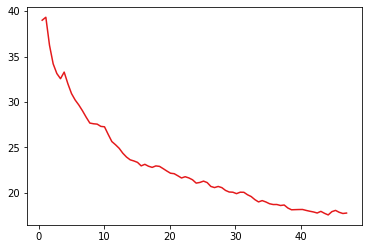

In [6]:
plt.plot(specfreqs[:84], group_spec[:,9][:84])

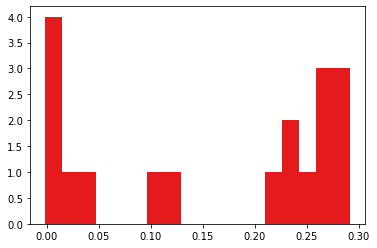

In [7]:
plt.hist(fg.get_params('aperiodic_params', 'exponent'), bins=18)
plt.show()

<function matplotlib.pyplot.show(*args, **kw)>

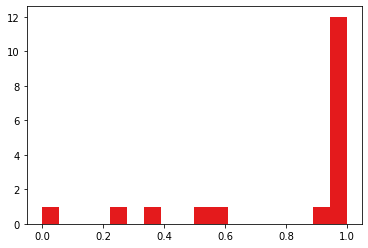

In [8]:
plt.hist(fg.get_params('r_squared'), bins=18); plt.show

# Load and fit data

Omit slopes lower than 0.05 (rough estimate) or goodness of fit
- Min peak height really a ratio 10^min_peak_height ~ 1.06

In [6]:
thresh = 0.1
group_df = load_and_fit(dimension = 'component', freqrange = [3,35], omit_r2 = 0.7, min_peak_height = .025)
list_peaks = 0
if list_peaks:
    for i, cl in enumerate(range(3,15)):
        peaks = group_df['cluster {}'.format(cl)]['peak data']['CF'][:,0]
        print('===Cluster {} oscillation freqs ==='.format(cl))
        peaks = sorted(peaks)
        for p in peaks:
            print('{:1.1f}'.format(p), end = ', ') #print with 1 decimal place
        print('\n')

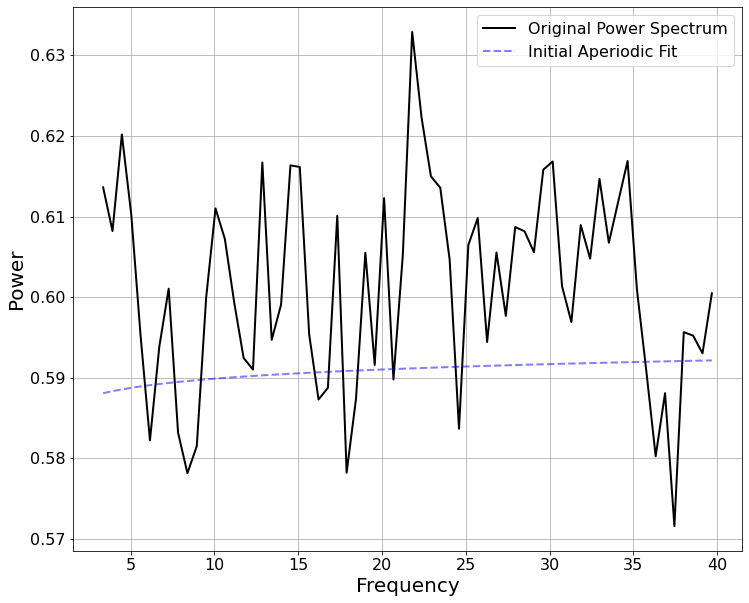

In [7]:
init_ap_fit = gen_aperiodic(fm.freqs, fm._robust_ap_fit(fm.freqs, fm.power_spectrum))
_, ax = plt.subplots(figsize=(12, 10))
plot_spectrum(fm.freqs, fm.power_spectrum, plt_log,
              label='Original Power Spectrum', color='black', ax=ax)
plot_spectrum(fm.freqs, init_ap_fit, plt_log, label='Initial Aperiodic Fit',
              color='blue', alpha=0.5, linestyle='dashed', ax=ax)

# Filter by ratio (Gaussian) on longer needed

In [11]:
# for the faltterned spectrum (initial aperiodic fit removed)
# flat_fm = fm.power_spectrum - init_ap_fit
# plot_annotated_peak_search(flat_fm)

In [12]:
import pylab as plb
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy import asarray as ar,exp
from array import array

In [13]:
# gaussian fit function
def gaus(x,a,x0,sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

In [14]:
# cluster iteration 
for clu_num in range(3,15):
    clu_id = 'cluster ' + str(clu_num)
    x = group_df[clu_id]['data']['freqs']
    y_collection = group_df[clu_id]['data']['spectra'] #note this is a ndarray
    component_num = y_collection.shape[1]
    
    # loop through components
    for i in range(component_num):
        n = len(x)
        y = []
        for i in range(i*n,(i+1)*n):
            y.append(y_collection.item(i))
        mean = sum(x*y)/n                   
        sigma = sum(y*(x-mean)**2)/n
        popt,pcov = curve_fit(gaus,x,y,p0=[1,mean,sigma]) #popt as fit
        
        peaks = group_df['cluster {}'.format(clu_num)]['peak data']
        peak_init_comp = group_df['cluster {}'.format(clu_num)]['peak data']['CF'][:,1]
        peak_comp = []
        # locate components with peak reported
        for i in peak_init_comp:
            if i not in peak_comp:
                peak_comp.append(i)
        
                

/opt/conda/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


In [15]:
peaks = group_df['cluster {}'.format(clu_num)]['peak data']
peak_init_comp = group_df['cluster {}'.format(clu_num)]['peak data']['CF'][:,1]
peak_comp = []
# locate components with peak reported
for i in peak_init_comp:
    if i not in peak_comp:
        peak_comp.append(i)
print(peak_comp)

[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 8.0, 9.0, 10.0, 12.0]


## Fit by initializing fooof

# example

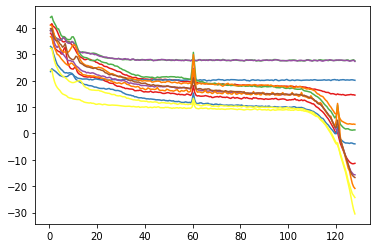

In [8]:
plt.plot(group_df['cluster 3']['data']['freqs'],group_df['cluster 3']['data']['spectra'])

In [9]:
# settings
cluster_check = group_df['cluster 3']
component_index = 0
freq_range_eg = [2,35]

In [10]:
spectra_cl3 = cluster_check['data']['spectra']
freq_eg = cluster_check['data']['freqs']
fm_trim = fooof.FOOOF()

# extra component spectrum from the 'spectra' as spectrum data is stored 'vertically'
component_spectra = []
for i in spectra_cl3:
    component_spectra.append(i[component_index])
spectra_eg = np.array(component_spectra)



FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.56 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 2 - 35 Hz                        
                                 Frequency Resolution is 0.56 Hz                                  
                                                                                                  
                            Aperiodic Parameters (offs

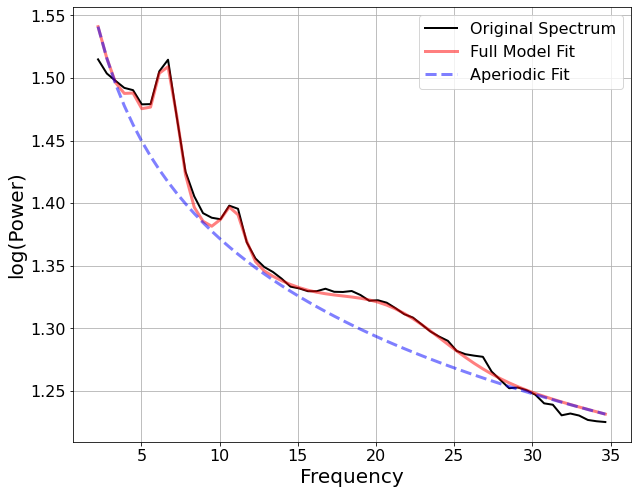

In [11]:
fm_trim.report(freq_eg, spectra_eg, freq_range_eg)

Ratio filter

In [22]:
ratio_criteria = 1.0


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.56 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

1th 6.590414295233727
1th 10.940440926453839
1th 21.536184173157533

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.56 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

2th 9.097499222042574
2th 19.79270957982339

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.56 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the fre

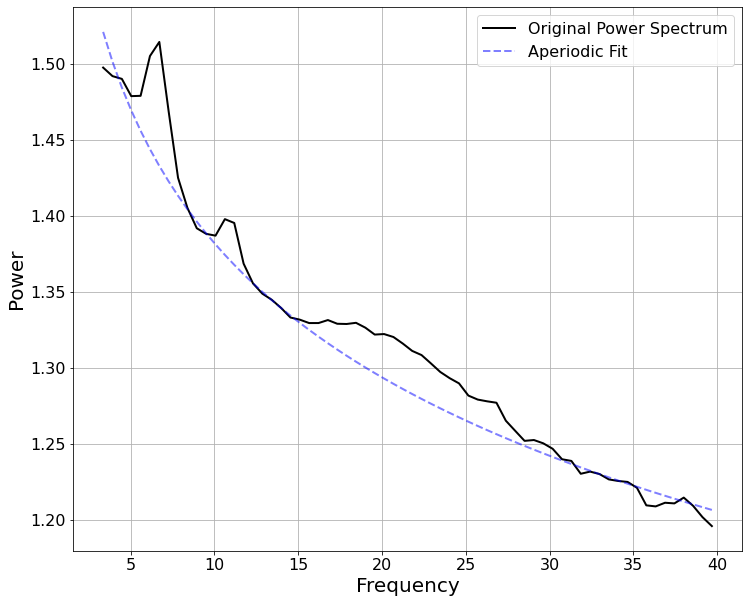

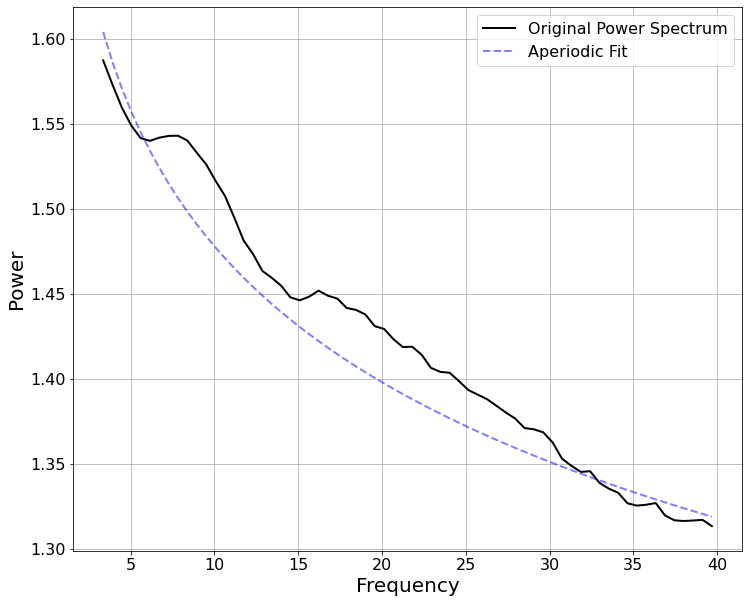

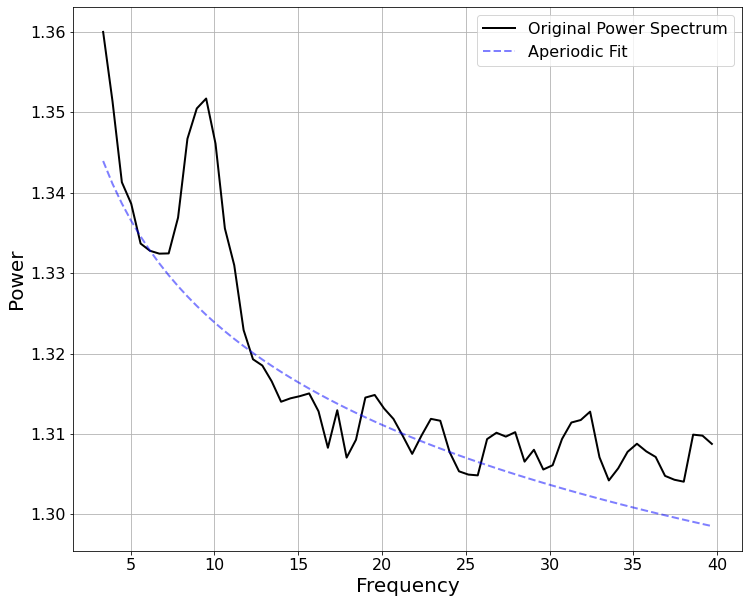

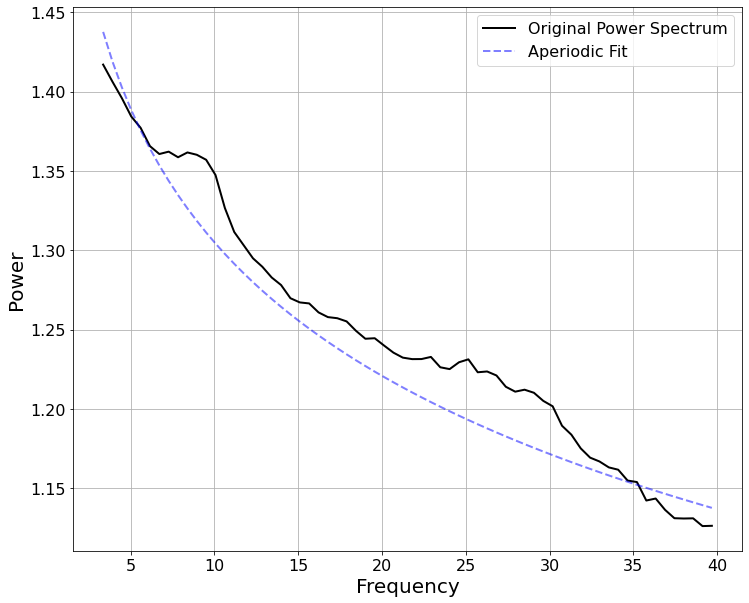

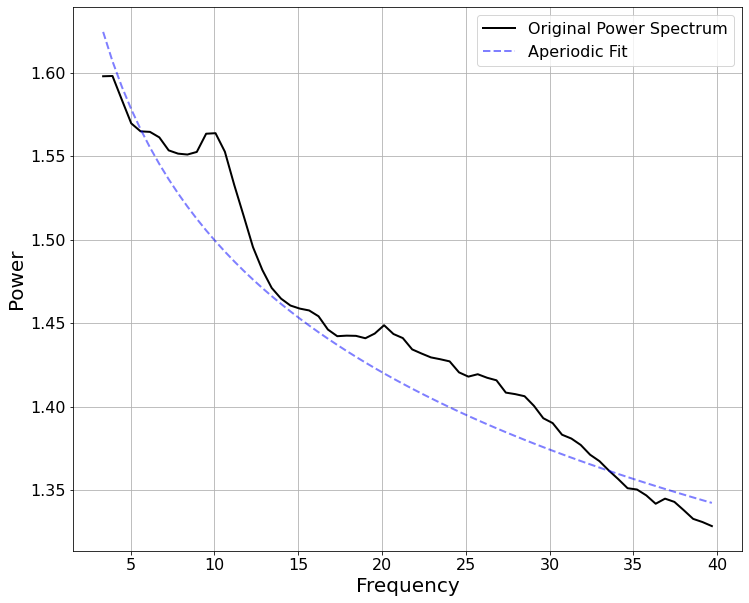

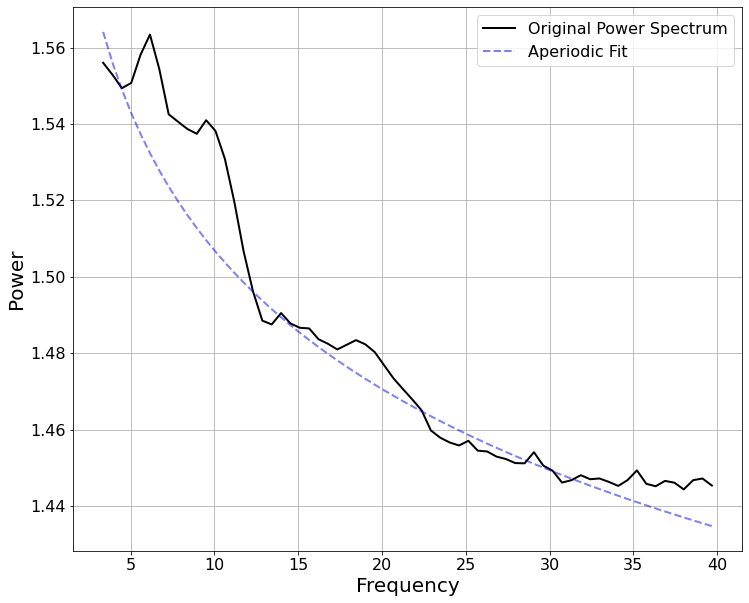

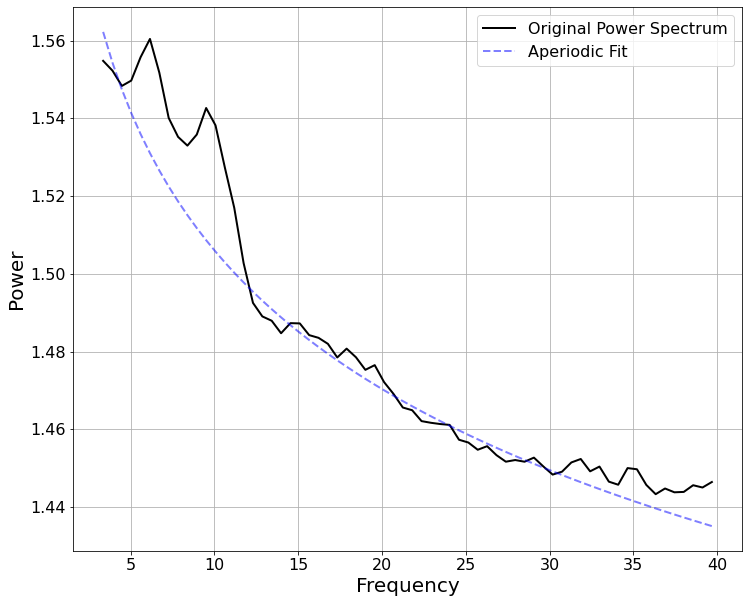

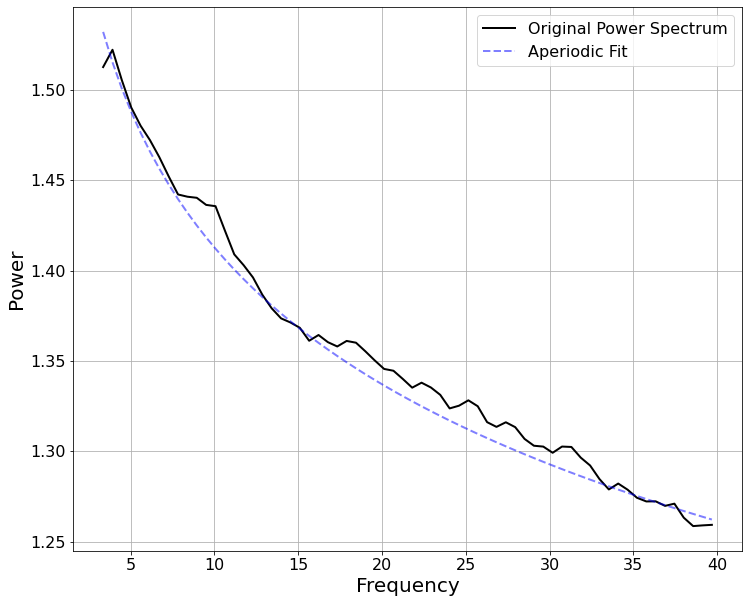

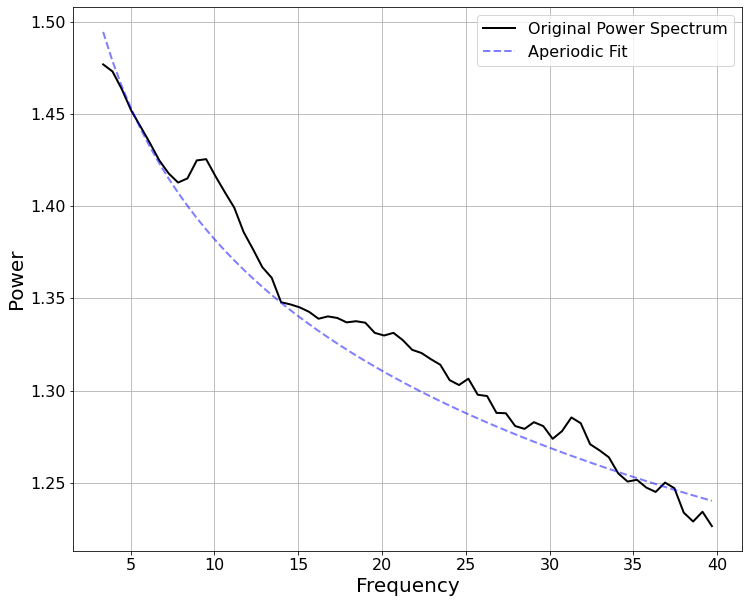

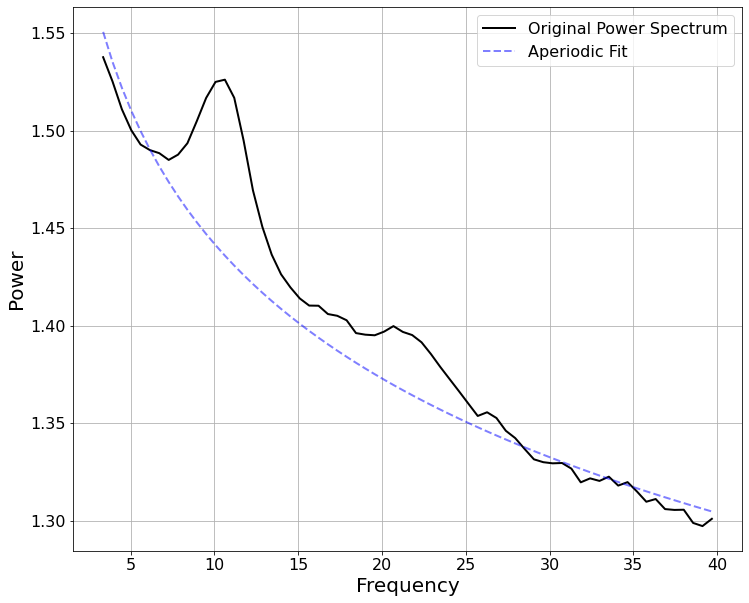

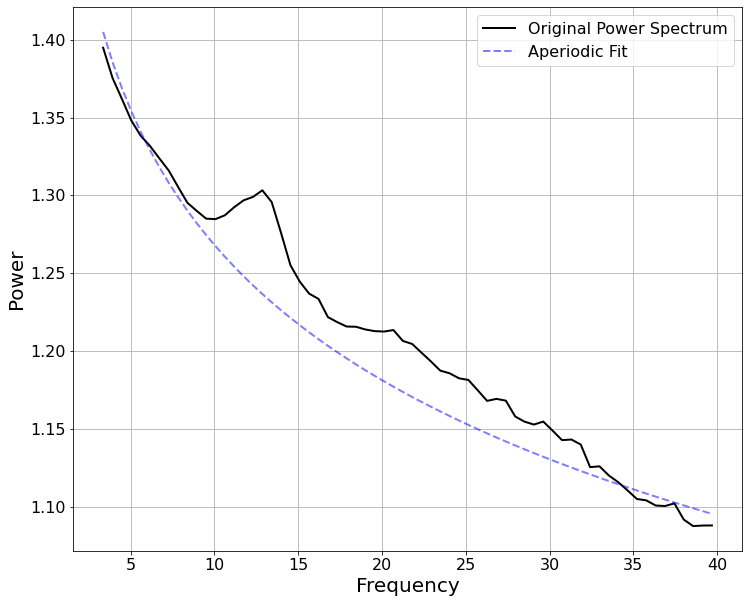

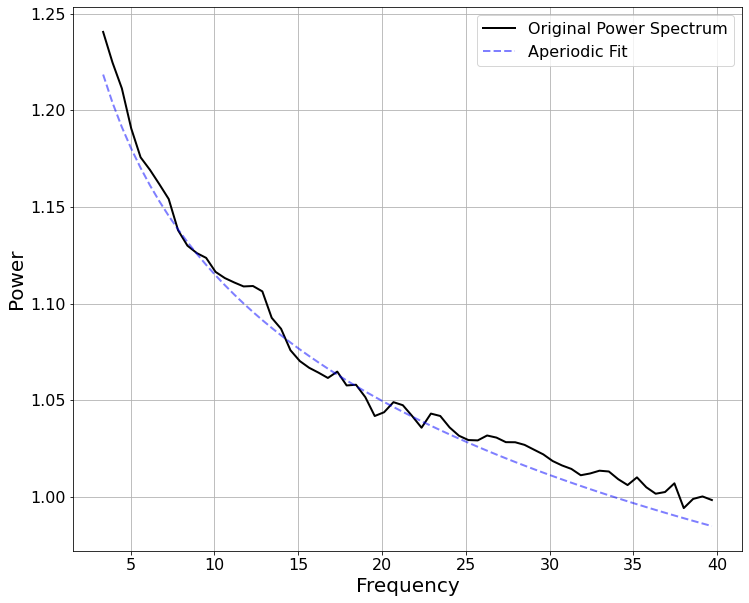

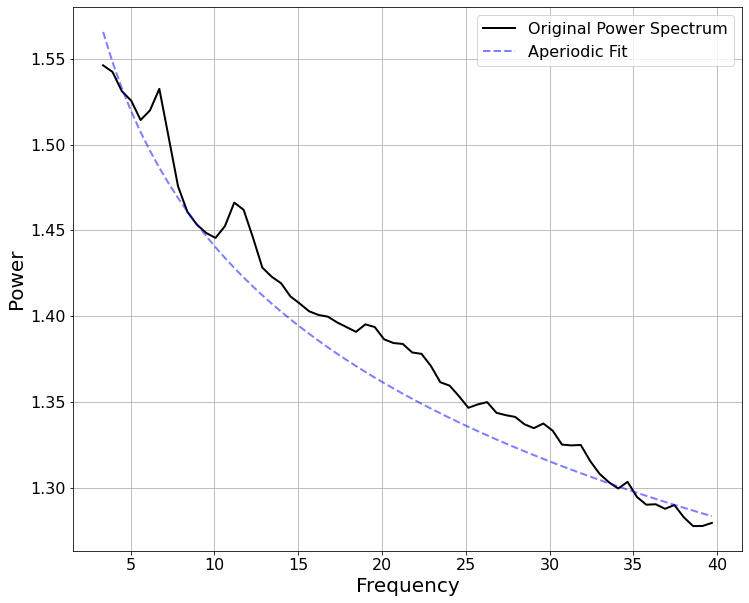

In [21]:
fit_data = group_df['cluster 3']
peak_data = fit_data['peak data']['CF']
component_size = int(np.size(fit_data['data']['spectra'])/np.size(fit_data['data']['freqs']))
spectra_cl = fit_data['data']['spectra']
freqs_cl = fit_data['data']['freqs']

# plot settings
# fig, axs = plt.subplots(component_size, 1)
# fig = plt.figure()
# fig.set_figheight(120)
# fig.set_figwidth(60)
# gs = fig.add_gridspec(component_size,1)
# fig, axs = plt.subplots(sharex=True, sharey=True)

cmap = LinearSegmentedColormap.from_list('mycmap', ['#111d6c', '#e03694'])
color = cmap(np.linspace(0, 1,n_))
mpl.rcParams['axes.prop_cycle'] = cycler.cycler('color', color)

# locate components that have peaks
peak_comps = peak_data[:,1] #components that have peaks
bumpy_comps = set([int(i) for i in peak_comps]) # articulate the components
#loop through components in the cluster
for comp in range(component_size):
    component_spectra = []
    x_coor = freqs_cl
    for i in spectra_cl:
        component_spectra.append(i[comp])
    y_coor = np.array(component_spectra)
    # FOOOF set up
    fm = fooof.FOOOF()
    plt_log = False
    freq_range = [3, 40]
    fm.fit(x_coor, y_coor, freq_range)
    # Fit
    init_ap_fit = gen_aperiodic(fm.freqs, fm._robust_ap_fit(fm.freqs, fm.power_spectrum))
    _, ax = plt.subplots(figsize=(12, 10))
    plot_spectrum(fm.freqs, fm.power_spectrum, plt_log, label='Original Power Spectrum', color='black', ax=ax)
    plot_spectrum(fm.freqs, init_ap_fit, plt_log, label='Aperiodic Fit', color='blue', alpha=0.5, linestyle='dashed', ax=ax)
    
    peak_freqs = []
    if comp in bumpy_comps:
        for i in peak_data:
            if i[1] == comp:
                peak_freqs.append(i[0])
                print(str(comp+1)+ 'th ' + str(i[0]))
                
                for fit_peak in init_ap_fit:
                    fit_peak 
    markers_on = [_prox_query(peak,component_spectra) for peak in peak_freqs]
    

    # plot settings
    # axs[comp].plot(x_coor, y_coor, '-gD', markevery=markers_on)
    # axs[comp].title.set_text(str(comp+1)+ 'th')
    # axs[comp].set_xlim([0, 100])

In [27]:
fit_data['peak data']['CF']

array([[ 6.5904143 ,  0.        ],
       [10.94044093,  0.        ],
       [21.53618417,  0.        ],
       [ 9.09749922,  1.        ],
       [19.79270958,  1.        ],
       [ 9.39620618,  2.        ],
       [ 9.34714666,  3.        ],
       [ 9.93792466,  4.        ],
       [ 6.31183919,  5.        ],
       [ 9.67555967,  5.        ],
       [ 6.35239344,  6.        ],
       [ 9.74081562,  6.        ],
       [10.09966851,  8.        ],
       [10.6040315 ,  9.        ],
       [20.80207393,  9.        ],
       [12.89171189, 10.        ],
       [ 6.71537929, 12.        ],
       [11.64079257, 12.        ]])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log
  import sys


1th 6.590414295160437
1th 10.940440926456382
1th 21.536184173677192
[0, 0, 0]

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.56 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

2th 9.097499221632697
2th 19.792709579268553
[1, 1]

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.56 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

3th 9.396206177812159
[1]

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.56 <= 0.50
	Lower bounds below frequency-resolution have

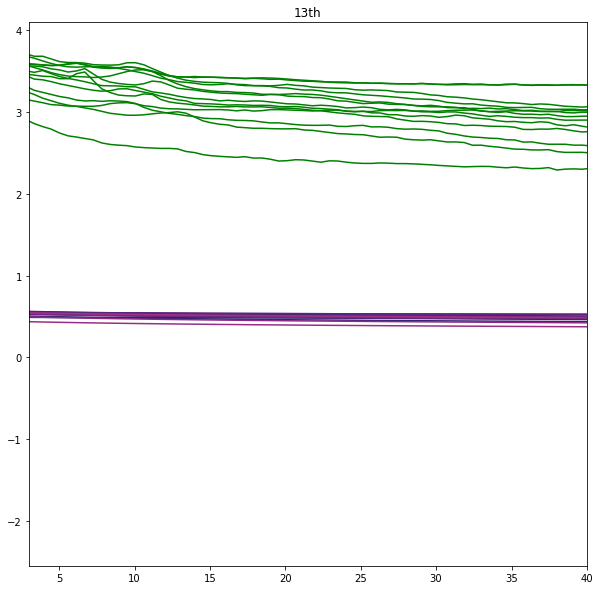

In [35]:
fit_data = group_df['cluster 3']
peak_data = fit_data['peak data']['CF']
component_size = int(np.size(fit_data['data']['spectra'])/np.size(fit_data['data']['freqs']))
spectra_cl = fit_data['data']['spectra']
freqs_cl = fit_data['data']['freqs']

log_spectea_cl = np.log(spectra_cl)

# plot settings
fig = plt.figure()
fig.set_figheight(10)
fig.set_figwidth(10)

cmap = LinearSegmentedColormap.from_list('mycmap', ['#111d6c', '#e03694'])
color = cmap(np.linspace(0, 1,n_))
mpl.rcParams['axes.prop_cycle'] = cycler.cycler('color', color)

# locate components that have peaks
peak_comps = peak_data[:,1] #components that have peaks
bumpy_comps = set([int(i) for i in peak_comps])
#loop through components in the cluster
for comp in range(13):
    component_spectra = []
    x_coor = freqs_cl
    for i in log_spectea_cl:
        component_spectra.append(i[comp])
    y_coor = np.array(component_spectra)
    
    peak_freqs = []
    if comp in bumpy_comps:
        for i in peak_data:
            if i[1] == comp:
                peak_freqs.append(i[0])
                print(str(comp+1)+ 'th ' + str(i[0]))
    markers_on = [_prox_query(p,component_spectra) for p in peak_freqs]
    print(markers_on)
    # plot the ap fit
    # converting to array
    component_spectra_ar = np.asarray(component_spectra)
    fm = fooof.FOOOF()
    fm.add_data(freqs_cl, y_coor,[3, 40])
    fm.fit(freqs_cl, y_coor, [3, 40])
    init_ap_fit = gen_aperiodic(fm.freqs, fm._robust_ap_fit(fm.freqs, fm.power_spectrum))

    # plot settings
    plt.plot(x_coor, y_coor, '-gD', markevery=markers_on)
    plt.title(str(comp+1)+ 'th')
    plt.xlim(3, 40)
    
    plt.plot(init_ap_fit, label = "aperiodic fit")

In [58]:
fm = fooof.FOOOF()
fm.add_data(freqs_cl, y_coor,[3, 40])
fm.power_spectrum

array([1.49765606, 1.49203838, 1.49021813, 1.47887343, 1.47907172,
       1.50524414, 1.51451255, 1.46863876, 1.42513375, 1.40538819,
       1.39198192, 1.38831238, 1.38712127, 1.39798017, 1.39545652,
       1.3687142 , 1.35573698, 1.3489661 , 1.34497204, 1.33959264,
       1.33328471, 1.33187273, 1.32963236, 1.32964   , 1.33161376,
       1.32917427, 1.32902417, 1.32979776, 1.32660387, 1.32206756,
       1.32240354, 1.32045809, 1.31613948, 1.31132521, 1.30858221,
       1.30310704, 1.29747085, 1.29340175, 1.289968  , 1.28193716,
       1.27931595, 1.2781683 , 1.27723651, 1.26542434, 1.2587673 ,
       1.2521642 , 1.25271301, 1.2505358 , 1.24695383, 1.24007353,
       1.2389674 , 1.23052269, 1.23194915, 1.23033903, 1.22681228,
       1.22577737, 1.22515209, 1.2213073 , 1.20975432, 1.20905531,
       1.21146617, 1.21103429, 1.21484929, 1.20941818, 1.20199972,
       1.19611193])

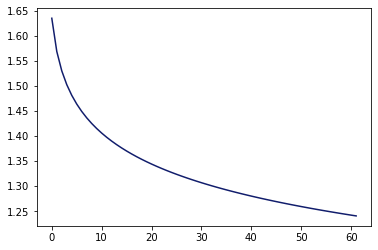

In [51]:
plt.plot(init_ap_fit)

In [ ]:
component_size = np.size(fit_data['data']['spectra'])/np.size(fit_data['data']['freqs'])
fig, (ax1, ax2) = plt.subplots(component_size)

plotFlatComps for single cluster and single component
plot_tools.py

In [13]:
def _prox_query(q, l, return_index = True):
    '''returns closest item in a list to query'''
    diffs = [np.abs(i - q) for i in l]
    if return_index:
        return diffs.index(min(diffs))
    else:
        return l[diffs.index(min(diffs))]

# plot single cluster
def plotSingleClFlatComps(fit_data, mark_peak, draw_omit = False):
    specfreqs, group_spec =  fit_data['data']['freqs'], fit_data['data']['spectra']    
    peak_data = fit_data['peak data']['CF']
    
    component_size = np.size(fit_data['data']['spectra'])
    fig, (ax1, ax2) = plt.subplots(component_size)
        
    peak_comps = peak_data[:,1] #components that have peaks
    bumpy_comps = set([int(i) for i in peak_comps])

    cmap = LinearSegmentedColormap.from_list('mycmap', ['#111d6c', '#e03694'])
    n_ = group_spec.shape[1] #number of components
    color = cmap(np.linspace(0, 1,n_))
    mpl.rcParams['axes.prop_cycle'] = cycler.cycler('color', color)
        
    flat_comps = 'Non osc comps: '
    for c in range(n_): #loop over comps
        peak_freqs = []
        if mark_peak:
            marker = 'D'
        else:
            marker = ''
        linestyle = '-'
            
        if c not in bumpy_comps:
            linestyle = '--'; marker = ''
            flat_comps += "{}, ".format(c)
        else: #append peaks to peak_freqs to read later and plot marker on spectra
            for p in peak_data:
                if p[1] == c:
                    peak_freqs.append(p[0])
        #convert freqs to x axis indeces
        #markers_on = [list(np.floor(specfreqs)).index(i) for i in np.floor(np.array(peak_freqs))]
        markers_on = [_prox_query(p,specfreqs) for p in peak_freqs]
        plt.semilogy(specfreqs[:84], group_spec[:,c][:84], marker = marker, linestyle = linestyle, markevery = markers_on, markersize=4)
        plt.ylabel('db'); 
    plt.title(flat_comps)
    plt.tight_layout()

In [17]:
list_peaks = 0
for i, cl in enumerate(range(3,15)):
    peaks = group_df['cluster {}'.format(cl)]['peak data']['CF'][:,0]

In [18]:
cluster_iter = []
for cluster_num in group_df:
    cluster_iter.append(cluster_num)


In [19]:
list_peaks = 0
for i, cl in enumerate(range(3,15)):
    peaks_power = group_df['cluster {}'.format(cl)]['peak data']['CF'][:,0]
    print(peaks_power)
    

[ 6.5904143  10.94044093 21.53618417  9.09749922 19.79270958  9.39620618
  9.34714666  9.93792466  6.31183919  9.67555968  6.35239344  9.74081562
 10.09966851 10.6040315  20.80207393 12.89171189  6.71537929 11.64079257]
[ 6.5904143  10.94044093 21.53618417  9.09749922 19.79270958  9.39620618
  9.34714666  9.93792466  6.31183919  9.67555968  6.35239344  9.74081562
 10.09966851 10.6040315  20.80207393 12.89171189  6.71537929 11.64079257]
[ 6.5904143  10.94044093 21.53618417  9.09749922 19.79270958  9.39620618
  9.34714666  9.93792466  6.31183919  9.67555968  6.35239344  9.74081562
 10.09966851 10.6040315  20.80207393 12.89171189  6.71537929 11.64079257]
[ 6.5904143  10.94044093 21.53618417  9.09749922 19.79270958  9.39620618
  9.34714666  9.93792466  6.31183919  9.67555968  6.35239344  9.74081562
 10.09966851 10.6040315  20.80207393 12.89171189  6.71537929 11.64079257]
[ 6.5904143  10.94044093 21.53618417  9.09749922 19.79270958  9.39620618
  9.34714666  9.93792466  6.31183919  9.6755596

In [152]:
group_df['cluster {}'.format(cl)]['peak data']['CF'][:,1]

array([ 0.,  0.,  0.,  1.,  1.,  2.,  3.,  4.,  5.,  5.,  6.,  6.,  8.,
        9.,  9., 10., 12., 12.])

In [ ]:
for p in peaks:
        print('{:1.1f}'.format(p), end = ', ') #print with 1 decimal place
        print('\n')

for cl in range(3,15):
    cl_serial = 'cluster ' + str(cl)
    peaks = group_df[cl_serial]['peak data']

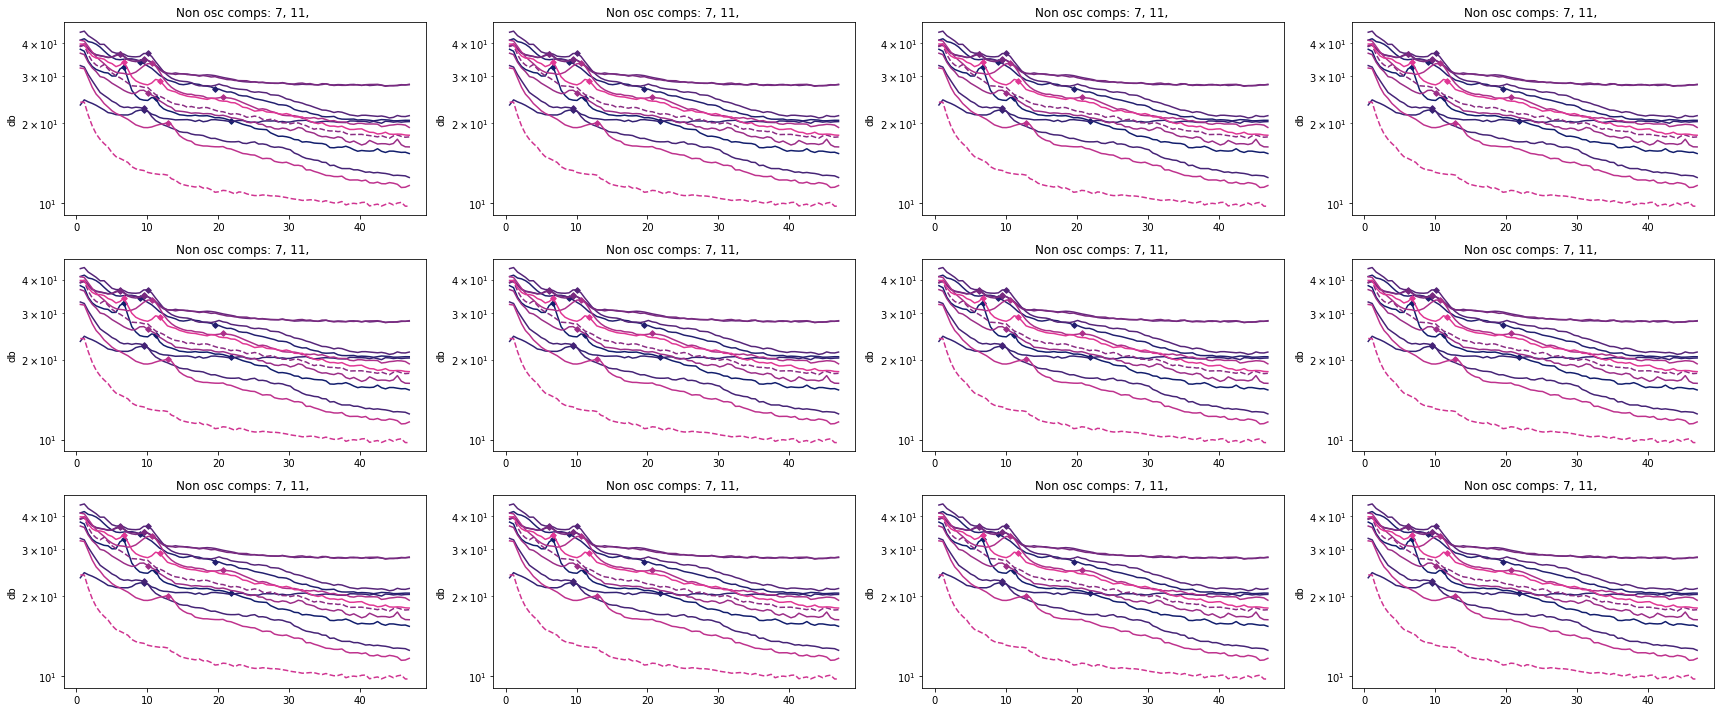

In [163]:
f = plt.figure(figsize=[24,10])
plotFlatComps(group_df, mark_peak = True) #warning: peak markers are at integer locations so may appear offset

save = 0
if save: f.savefig('./fig/fig', dpi = 300)

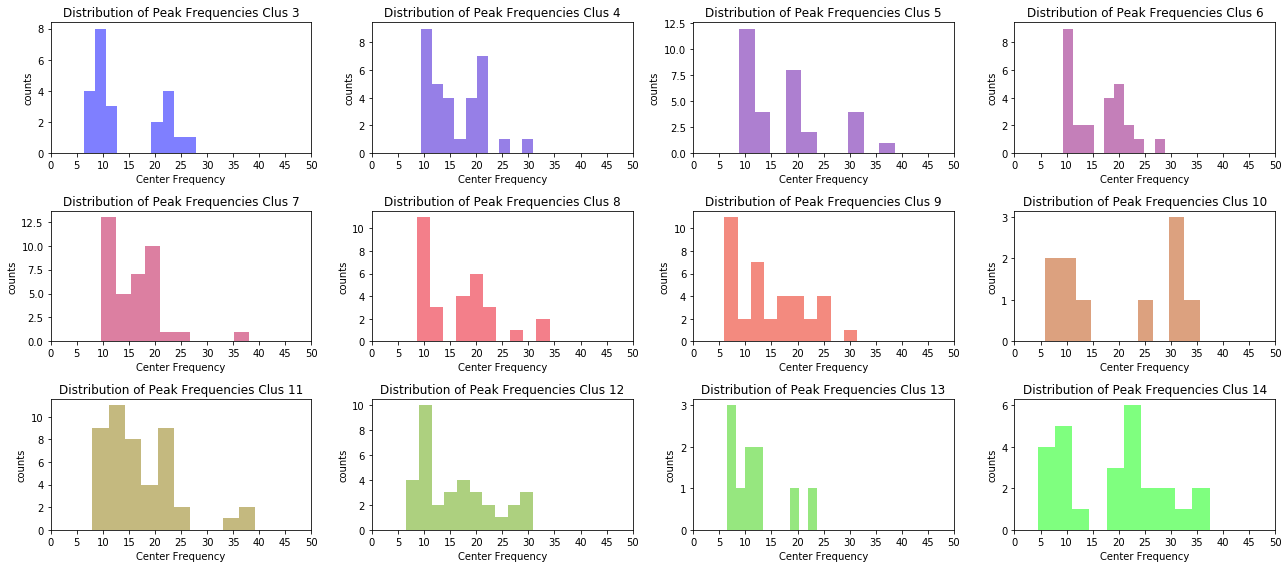

In [22]:
plt.figure(figsize=[18,8])
peakPlot(group_df, 'CF', plt_format = 'subplots')

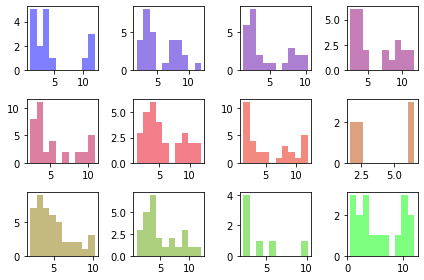

In [5]:
peakPlot(group_df, 'BW', plt_format = 'subplots')
plt.show()

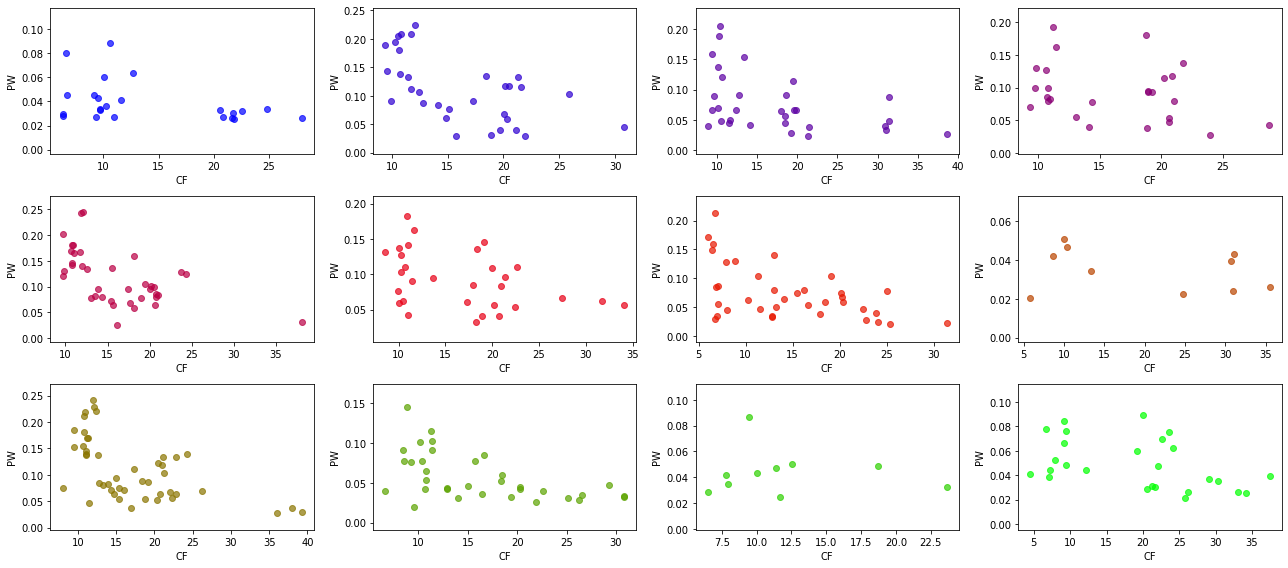

In [7]:
plt.figure(figsize=[18,8])
#peakDataScatter(group_df) #
peakDataScatter(group_df, measures = ['CF','PW'])

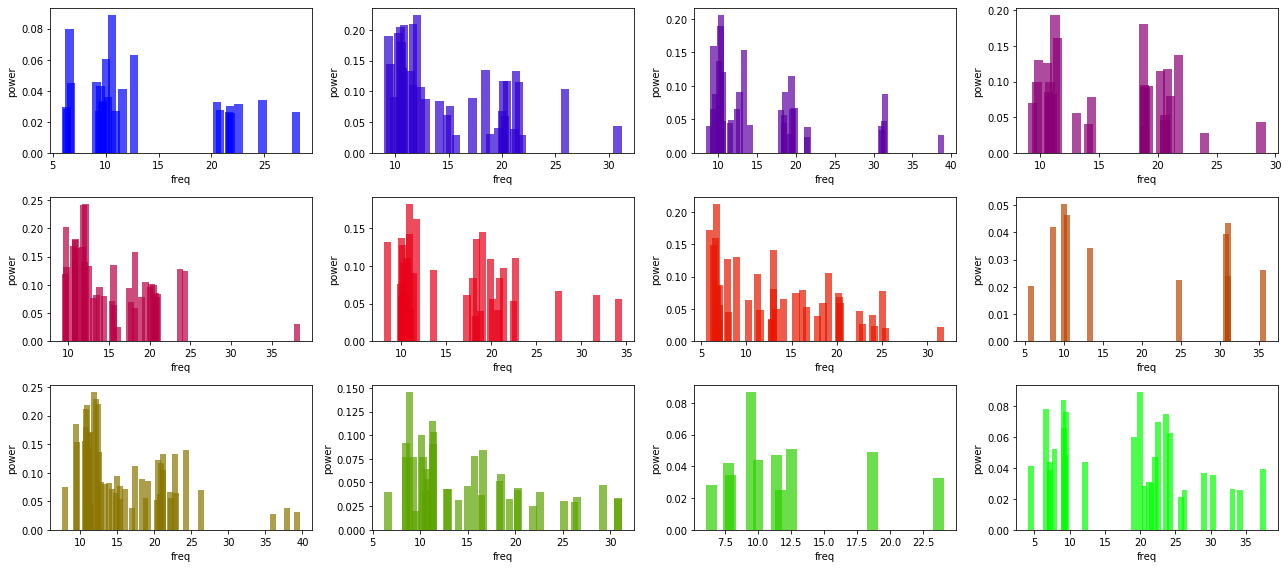

In [6]:
plt.figure(figsize=[18,8])
#peakDistr(group_df, order = 'sorted')
#peakDistr(group_df, plt_format = 'layered')
peakDistr(group_df)

# Ratio Analysis

(array([36., 31., 69., 23.,  7.,  8., 10.,  9.,  8.,  1.,  0.,  1.,  0.,
         0.,  1.]),
 array([1.12761222, 1.41111586, 1.69461951, 1.97812316, 2.26162681,
        2.54513046, 2.82863411, 3.11213776, 3.39564141, 3.67914506,
        3.96264871, 4.24615236, 4.529656  , 4.81315965, 5.0966633 ,
        5.38016695]),
 <a list of 15 Patch objects>)

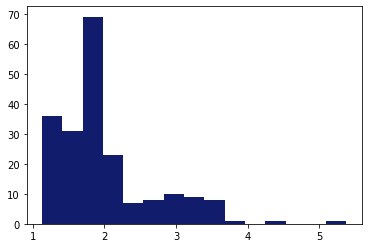

In [31]:
def calc_ratios(fit_data):
    """Compute ratio between oscillation freqs for all components, if multiple oscillations in spectrum"""
    ratios = dict()
    ratio_list = []
    for cl in range(3,15):        
        peak_data = fit_data['cluster {}'.format(cl)]['peak data']['CF']
        osc_dict = invert_peak_data(peak_data) #easier to read format
        ratios['clust %s'%cl] = dict()
        for c in osc_dict.keys():
            if len(osc_dict[c]) > 1:
                freqs = osc_dict[c]
                ratios_c = []
                curr_denom = freqs[0]
                for f in freqs[1:]:
                    ratios_c.append(f/curr_denom)
                    ratio_list.append(f/curr_denom)
                    #curr_denom = f
                ratios['clust %s'%cl][c] = ratios_c
                
    return ratios, ratio_list

rat, rat_l = calc_ratios(group_df)
plt.hist(rat_l, bins = 15)

# Modality separation

In [ ]:
def id_modes(fit_data):
    """Separating components by mu/alpha and beta"""
    alpha = []
    beta = []
    oscillations = {'delta' : [0.5,4], 'theta' : [4,8], 'alpha' : [8,13], 'beta' : [13,30], 'gamma' : [30,90]}
    for o in oscillations.keys():
        o_range = oscillations[o]
        min_, max_ = o_range[0], o_range[1]
            for i, cl in enumerate(range(3,15)):
                peak_data = fit_data['cluster {}'.format(cl)]['peak data']['CF']
                o_peaks = [] # peaks at oscillation o for cluster cl
                clus_peaks = peaks[i]
                for peak in clus_peaks:
                    if min_ <= peak[0] <= max_:
                        o_peaks.append(peak)

                if len(o_peaks) == 4:
                    pass

# Comparison chart
Originally done in MATLAB for ERPs

threshold 0.02

indices: PL, PR, TL, TR

3 statistics: freq, amplitutde, exponent

In [13]:
group_df2 = load_and_fit(dimension = 'condition', freqrange = [3,40], min_peak_height=0)
peaks = []
for i, cl in enumerate(range(3,15)):
    peaks.append(group_df2['cluster {}'.format(cl)]['peak data']['CF']) #[:,0]) 
#oscillations = {'delta' : [0.5,4], 'theta' : [4,8], 'alpha' : [8,13], 'beta' : [13,30], 'gamma' : [30,90]}
oscillations = {'delta' : [0.5,4], 'theta' : [4,8], 'alpha' : [8,13], 'theta-alpha': [4,13], 'beta' : [13,30], 'gamma' : [30,90]} # with theta/alpha

### peaks format should be [freqs, pow, condition]
- though freq differences may be interesting as well

In [22]:
group_df2['cluster {}'.format(13)]['peak data']['CF']

array([[ 7.60460379,  0.        ],
       [10.70467258,  0.        ],
       [23.53136524,  0.        ],
       [10.24757059,  1.        ],
       [23.29629652,  1.        ],
       [24.4419159 ,  1.        ],
       [10.09271404,  2.        ],
       [23.81328201,  2.        ],
       [31.7301746 ,  2.        ],
       [ 6.23875572,  3.        ],
       [10.25044306,  3.        ],
       [24.81426284,  3.        ],
       [33.64781744,  3.        ],
       [33.81815164,  3.        ],
       [36.27487544,  3.        ],
       [38.81694802,  3.        ]])

In [14]:
diffs = dict()
for o in oscillations.keys():
    #print('++++++OSC', o)
    o_range = oscillations[o]
    min_, max_ = o_range[0], o_range[1]
    o_diffs = {'x':[], 'y':[], 'cl':[]} # to have x and y arrays
    
    for i, cl in enumerate(range(3,15)): #loop through clusters
        o_peaks = [] # peaks at oscillation o for cluster cl, make sure these are indexed properly
        clus_peaks = peaks[i]
        #this case assumes 4 peaks distr across conditions
        for peak in clus_peaks:
            if min_ <= peak[0] < max_: # if in peak range
                o_peaks.append(peak)
        #loop over conditions, if more than 1, avg the heights of the two 
        # ... code
                
        if len(o_peaks) == 4: # What do you do if more than 4?
            RL_P = o_peaks[1][0] - o_peaks[0][0]; RL_T = o_peaks[3][0] - o_peaks[2][0] # PR - PL; TR- TL
            PT_L = o_peaks[0][0] - o_peaks[2][0]; PT_R = o_peaks[1][0] - o_peaks[3][0] # PL - TL ; PR - TR

            RL = np.mean([RL_P, RL_T]) # mean([(PR - PL), (TR - TL)])
            PT = np.mean([PT_L, PT_R]) # mean([(PL - TL), (PR - TR)]) 

            o_diffs['x'].append(RL)
            o_diffs['y'].append(PT)
            o_diffs['cl'].append('  {}'.format(cl))
        #print('CLUS',cl,'\n', o_peaks)        
    
    if len(o_diffs['x']) != 0:
        diffs[o] = o_diffs

In [15]:
diffs

{'theta': {'x': [-0.06819310557005176, 0.07436025361592424],
  'y': [0.024858354455628895, 0.05130361848198106],
  'cl': ['  3', '  9']},
 'alpha': {'x': [-0.10524283486420138,
   -0.0629958459375608,
   0.011527361528996138,
   0.04503866540758583,
   -0.3793089775838929,
   0.20168478569592274,
   -0.14968648087320258],
  'y': [0.1533772906741966,
   -0.02316766973758,
   -0.1308232222748309,
   -0.032874634023493776,
   -0.012741482828152684,
   0.3483538561298509,
   0.3045430393312616],
  'cl': ['  3', '  6', '  7', '  8', '  10', '  11', '  13']},
 'theta-alpha': {'x': [-0.0629958459375608,
   0.011527361528996138,
   0.04503866540758583,
   0.20168478569592274,
   0.27794825458426553],
  'y': [-0.02316766973758,
   -0.1308232222748309,
   -0.032874634023493776,
   0.3483538561298509,
   0.3813771416023042],
  'cl': ['  6', '  7', '  8', '  11', '  14']},
 'beta': {'x': [0.05378044535214954,
   -0.13196557107956686,
   -0.0761062551911511,
   -3.6353312050394386,
   -0.0359478390

2 x 8 (2x2 freqs, 2x2 peak diff )

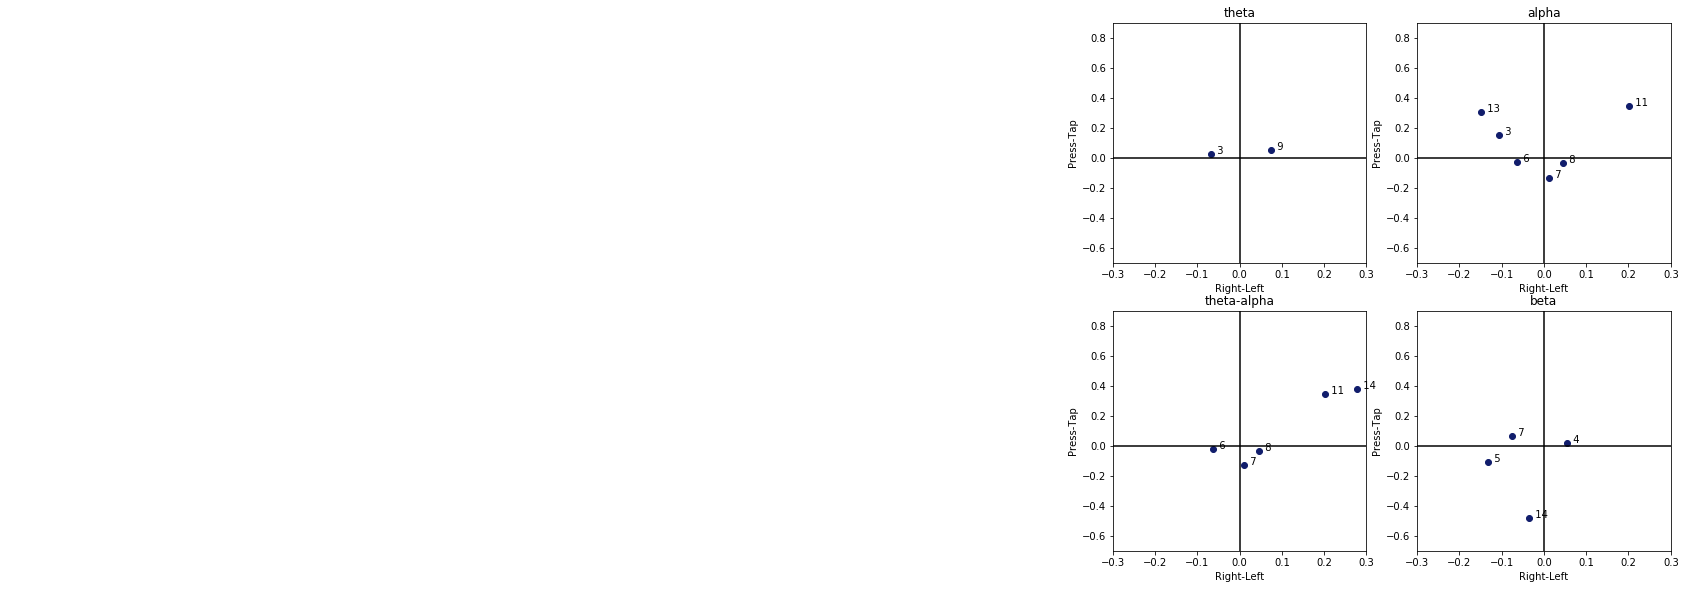

In [30]:
plt.figure(figsize=[10,15])
for i, o in enumerate(diffs.keys()):
    plt.subplot(3,2,i+1)
    x, y = diffs[o]['x'], diffs[o]['y']
    plt.scatter(x,y)
    plt.ylim([-0.7, 0.9]); plt.xlim([-0.3, 0.3])
    for t_i, txt in enumerate(diffs[o]['cl']):
        plt.annotate(txt, (x[t_i], y[t_i]))
    plt.axhline(0, color = 'k'); plt.axvline(0, color = 'k')
    #plt.tight_layout()
    
    plt.title(o)
    plt.xlabel('Right-Left'); plt.ylabel('Press-Tap');

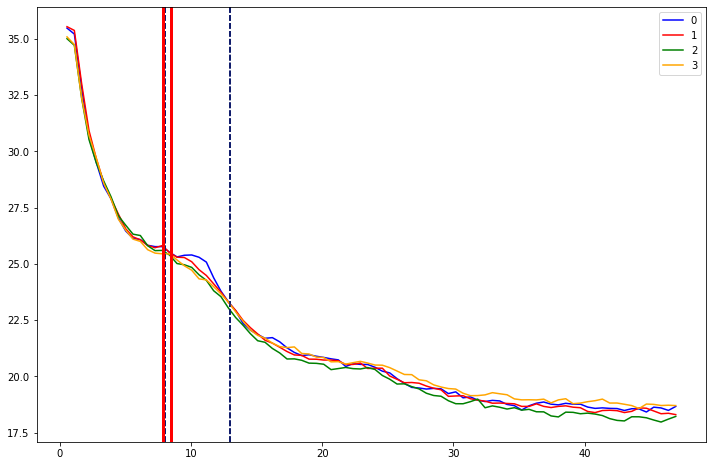

In [21]:
p_spectrum = loadmat('./data/spectra/dip_only/brian_diponly_{}_spectra.mat'.format(13))
specfreqs, specdata = p_spectrum['specfreqs'][0], p_spectrum['specdata']
group_spec = np.array([specdata[i][0].mean(1) for i in range(4)])
colors = ['b','r','g','orange'] # PL, PR, TL, TR
plt.figure(figsize=[12,8])
for i in range(4):
    plt.plot(specfreqs[:84], group_spec[i][:84], color = colors[i], label = str(i))
    #plt.xlim([5,14])
    # theta - alpha range
     plt.axvline(4, linestyle = '--'); plt.axvline(13, linestyle = '--')
        #cl14 peaks
#     plt.axvline(8.5, color = 'red', lw = 3);     plt.axvline(7.85, color = 'red', lw = 3)
    plt.axvline(8.5, color = 'red', lw = 3);     plt.axvline(7.85, color = 'red', lw = 3)

plt.legend()

In [ ]:
single_spec_fit = dict.fromkeys(['cluster {}'.format(i) for i in range(3,15)])
for k in single_spec_fit.keys():
    single_spec_fit[k] = {'PR':[], 'PL':[], 'TL':[], 'TR':[]}    

# Some tests 
Just to see how to use FOOOF and how to load exported spectral data
- Notice the variance in the non averaged spectrum.  

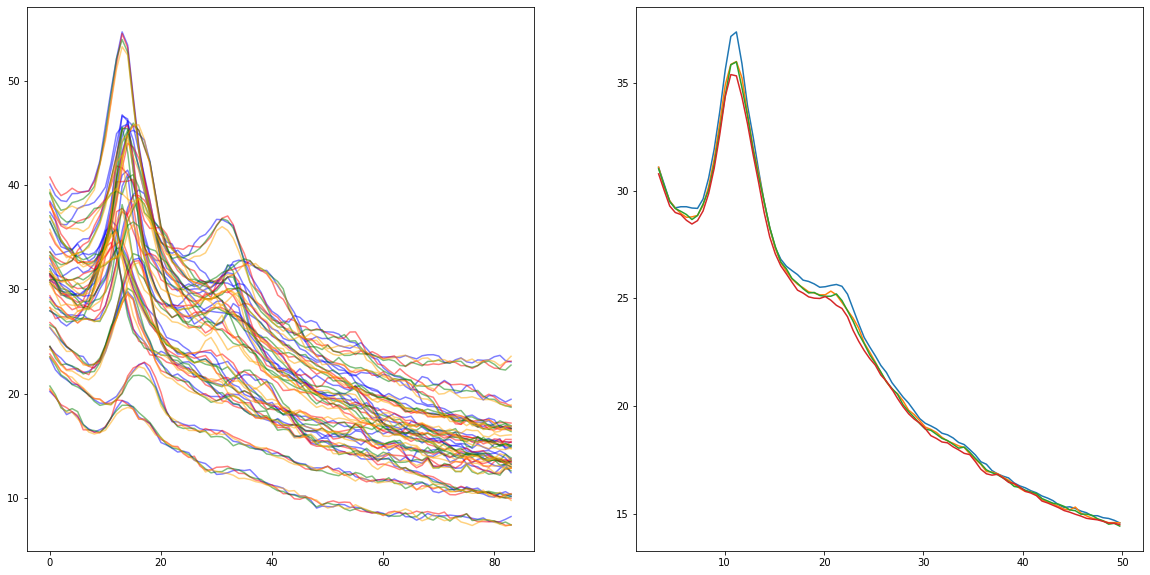

In [6]:
# data from dipole location + ERSP clustering; cluster 5
p_spectrum = loadmat('./data/spectra/dip5_specdata.mat')
specfreqs, specdata = p_spectrum['specfreqs'][0], p_spectrum['specdata']

group_spec = np.array([specdata[i][0].mean(1) for i in range(4)])# shaped 4x84, averaged across 16 components

plt.figure(figsize=[20,10])
plt.subplot(1,2,1)
colors = ['b','r','g','orange']
for i in range(4):
    plt.plot(specdata[i][0], color = colors[i], alpha = 0.5)

plt.subplot(1,2,2)
for i in range(4):
    plt.plot(specfreqs, group_spec[i])
    
#plt.legend()

Running FOOOFGroup across 4 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.56 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 4 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.56 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

                                                                                                  
                                       FOOOF - GROUP RESULTS                                      
            

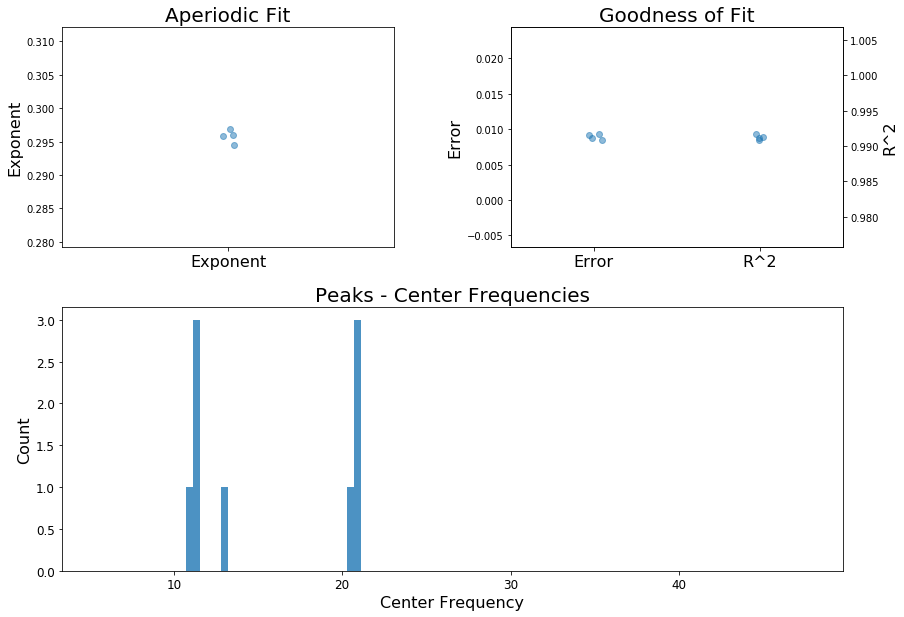

In [42]:
fg = fooof.FOOOFGroup()
fg.fit(specfreqs, group_spec)
freqrange = [3,50]
fg.report(specfreqs, group_spec, freqrange)

## Single FOOOF - One condition


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.56 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.56 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  

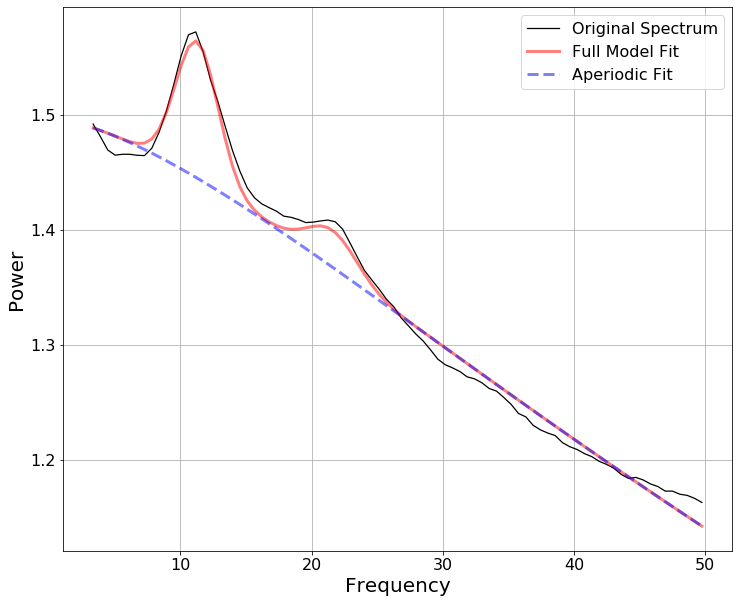

In [4]:
fg = fooof.FOOOF(aperiodic_mode='knee')
fg.fit(specfreqs, group_spec[0])
freqrange = [3,50]
fg.report(specfreqs, group_spec[0], freqrange)

# All dipole only clusters

This spectrum has 229 points for some reason

In [10]:
dip_only_spec = loadmat('./data/dip_only/brian_diponly_all_spectra.mat')


In [18]:
dip_only_spec['specdata'][0][0].shape


(229, 11)

In [20]:
dip_only_spec['specfreqs'].shape

(1, 229)

In [29]:
dip_only_spec3 = loadmat('./data/dip_only/brian_diponly_3_spectra.mat')
specfreqs3, specdata3 = dip_only_spec3['specfreqs'][0], dip_only_spec3['specdata']

group_spec3 = np.array([specdata3[i][0].mean(1) for i in range(4)])# shaped 4x84, averaged across 16 components

In [30]:
dip_only_spec3['specdata'][0][0].shape

(229, 18)

In [34]:
group_spec3.shape

(4, 229)

In [33]:
group_spec.shape

(4, 84)